# Pokemon Card Classifier

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import base_set_classifier.data as data

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
K.set_session(tf.Session(config=config))

/media/Data/Programs/Pkmn_card_classifier/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/Data/Programs/Pkmn_card_classifier/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/Data/Programs/Pkmn_card_classifier/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/media/Data/P

In [2]:
# functions
def print_experiments(mnt_pt):
    for experiment in os.listdir(mnt_pt):
        experiment_path = mnt_pt + '/' + experiment
        print('Experiment {0} directory: {1}'.format(experiment, experiment_path))
        for directory in os.listdir(experiment_path):
            if directory == 'dataset':
                print('dataset path: {} \n'.format(experiment_path + '/' + directory))
            else:
                print('no dataset directory in experiment directory: {0}, subdirectories are: {1}'.format(experiment, os.listdir(experiment_path)))

In [3]:
### Constants
# file constants
data_csv_path = '/media/Data/Programs/Pkmn_card_classifier/data/processed.csv'
images_path = '/media/Data/Programs/Pkmn_card_classifier/data/images/'
# data properties
img_size = (550,400) # (height, width) in pixels
color_mode = 'rgb'
batch_size = 32
random_seed = 20

## Exploratory Data Analysis

In [4]:
df = pd.read_csv(data_csv_path)
dataset_size = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10984 entries, 0 to 10983
Data columns (total 2 columns):
filename    10984 non-null object
class       10984 non-null object
dtypes: object(2)
memory usage: 171.8+ KB


#### Class Frequency Histogram

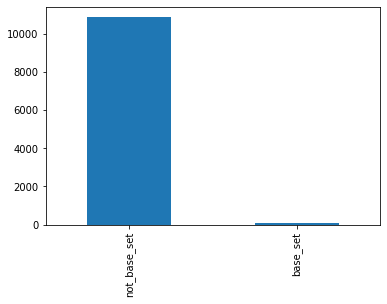

In [5]:
class_count = df['class'].value_counts()
class_count.plot.bar()

In [6]:
print(class_count)
print()
for c in class_count.index:
    print('Expected value for probability of drawing a {0} sample from our dataset: {1}'.format(c, class_count[c] / dataset_size))

not_base_set    10882
base_set          102
Name: class, dtype: int64

Expected value for probability of drawing a not_base_set sample from our dataset: 0.9907137654770576
Expected value for probability of drawing a base_set sample from our dataset: 0.009286234522942461


### Conclusions

We can clearly see from the above histogram that our dataset is very unbalanced and that we can expect an average (expected value) accuracy of 0.9907 for classification if we constructed a model that only predicted not_base_set for all examples in our sample dataset since the probability of encountering a non_base_set example is 0.9907. A classifier of this design would have great accuracy scores but would have trouble predicting examples that are truely base_set. This suggests that classification accuracy might not be the best measure of our models performance and that maybe we should look at the precision, recall, and F1 scores of our specific classes. Assuming our dataset sample is a representative sample of the total population of all possible base set pokemon card images and non base set pokemon card images that will ever be uploaded to the app then there would be no issue with the unbalancedness of this dataset, but if it isn't a representative sample of the population then our classifier would have a heavy bias on predicting not base set. This assumption is unlikely to be valid because there is no good reason to suggest that users would prefer to upload more images of one class than the other. Which means that a classifier trained on this dataset and cross validated for highest accuracy would most likely be heavily biased on labeling examples as non base set, and would perform pretty poorly when deployed.

There are a couple of ways we can deal with the above problem.
1. Undersample our most represented class, and maximize accuracy when we think our sample is representative. The issue though is the amount of examples of our under represented class (or over represented class after undersampling) might not be enough for our model to learn to identify them, and we would have to bias our model more in order to achieve better results (but overall worse results than our higher variance model trained on more data)
2. Oversample our under represented class, and maximize accuracy when we think our sample is representative. The issue with this solution is that at some point if we oversample too much the model might overtrain on the under represented class and not generalize well in deployment.
3. Oversample our under represented class with image augmentation. Again the downside to this solution is that our image augmentation might not be strong enough to produce examples that are different enough from the ones we started with and this will eventually cause overtraining.
4. Brute force search for model architectures that can learn to maximize our precision, recall, and F1 metrics from the limited amount of data we have for our under represented class. The problem with this solution is that the models we might find might not perform as well as we want on these metrics because the models that are capable of learning from our limited amount of data for our under represented class might be heavily biased, making the overall scores on our metrics not high.
5. Change our loss function to penalize wrong classification of the under represented class more than that of the over represented class.
6. Gather more data!!

## Model Development

Since we are more concerned with our model identifying base set examples than non base set examples the metrics we should be concerned with are the precision, recall and F1 scores for our base set class. **Since recall is essentially our accuracy score on predicting base set examples, and precision is our measure of certainty on our predictions of base set, we naturally would want to maximize both. This implies we should maximize our F1 score since it is the unweighted harmonic mean of our precision and recall scores.**

Solutions 1-3

#### Data Preprocessing

In [7]:
# Helper Functions

def print_dataset_info(df, name):
    """
    Prints size of dataframe, and value counts
    df: type DataFrame, with columns=['filename', 'class']
    name: type String, name of the dataset
    ---> None
    """
    df_size = len(df)
    class_count = df['class'].value_counts()
    print('Size of {0}: {1}'.format(name, df_size))
    print()
    print('Class counts for {0}:'.format(name))
    print(class_count)
    return None

In [8]:
# Splitting dataset into a train set, validation set, and test set

test_proportion = 1/5
val_proportion = 1/5

# reading csv into dataframe and transforming filenames into file paths
df = pd.read_csv(data_csv_path)
df['filename'] = df['filename'].map(lambda f: os.path.join(images_path, f))

# Splitting dataset into train, validation, and test datasets
df_train, df_val, df_test = data.train_val_test_split(df, test_proportion, val_proportion, seed=random_seed)

# Calculating and printing some useful values about the train, validation, and test datasets
print_dataset_info(df_train, 'training set')
print()
print()
print_dataset_info(df_val, 'validation set')
print()
print()
print_dataset_info(df_test, 'test set')

Size of training set: 6590

Class counts for training set:
not_base_set    6529
base_set          61
Name: class, dtype: int64


Size of validation set: 2197

Class counts for validation set:
not_base_set    2176
base_set          21
Name: class, dtype: int64


Size of test set: 2197

Class counts for test set:
not_base_set    2177
base_set          20
Name: class, dtype: int64


In [9]:
# Upsampling and downsampling datasets

class_samples_train = {'base_set': 100, 'not_base_set': 100}
class_samples_val = {'base_set': 40, 'not_base_set': 40}
class_samples_test = None

replacement_train = {'base_set': True, 'not_base_set': False}
replacement_val = {'base_set': True, 'not_base_set': False}
replacement_test = None

df_train = data.sample_dataset(df_train, samples_per_class=class_samples_train, replacement=replacement_train, 
                               seed=random_seed)
df_val = data.sample_dataset(df_val, samples_per_class=class_samples_val, replacement=replacement_val, seed=random_seed)
df_test = data.sample_dataset(df_test, samples_per_class=class_samples_test, replacement=replacement_test,
                              seed=random_seed)


In [10]:
# Calculating and printing some useful values for the sampled datasets
print_dataset_info(df_train, 'training set')
print()
print()
print_dataset_info(df_val, 'validation set')
print()
print()
print_dataset_info(df_test, 'test set')

Size of training set: 200

Class counts for training set:
not_base_set    100
base_set        100
Name: class, dtype: int64


Size of validation set: 80

Class counts for validation set:
not_base_set    40
base_set        40
Name: class, dtype: int64


Size of test set: 2197

Class counts for test set:
not_base_set    2177
base_set          20
Name: class, dtype: int64


In [11]:
# mapping dataframe classes to their binary classification encodings
"""
This is necessary because tf.keras.preprocessing.image.ImageDataGenerator's flow_from_dataframe doesn't work, 
specifically the classes arguement does not function.
"""

mapping = {'not_base_set': '0', 'base_set': '1'}

df_train['class'] = df_train['class'].map(lambda foo: mapping[foo])
df_val['class'] = df_val['class'].map(lambda foo: mapping[foo])
df_test['class'] = df_test['class'].map(lambda foo: mapping[foo])

In [12]:
# Augmenting datasets 
train_datagen = ImageDataGenerator(height_shift_range=0.5, rotation_range=90, horizontal_flip=True, vertical_flip=True)
valid_datagen = ImageDataGenerator(height_shift_range=0.5, rotation_range=90, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(height_shift_range=0.5, rotation_range=90, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(df_train, target_size=img_size, class_mode='binary',
                                                    batch_size=batch_size, drop_duplicates=False, seed=random_seed)
valid_generator = valid_datagen.flow_from_dataframe(df_val, target_size=img_size, class_mode='binary',
                                                    batch_size=batch_size, drop_duplicates=False, seed=random_seed)
test_generator = test_datagen.flow_from_dataframe(df_test, target_size=img_size, class_mode='binary',
                                                  batch_size=batch_size, drop_duplicates=False, seed=random_seed)

print(train_generator.class_indices)
print(valid_generator.class_indices)
print(test_generator.class_indices)

Found 200 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 2197 validated image filenames belonging to 2 classes.
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}


#### Models

In [13]:
def model_1(): 
    inputs = k.Input(shape=(*img_size, 3))
    x = k.layers.Conv2D(5, (2,2), strides=(1,1), padding='same', 
                      input_shape=(*img_size, 3), activation='relu')(inputs)
    x = k.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
    x = k.layers.Conv2D(10, (5,5), strides=(1,1), padding='same', activation='relu')(x)
    x = k.layers.MaxPooling2D(pool_size=(5,5), strides=(5,5), padding='valid')(x)
    x = k.layers.Conv2D(25, (10,10), strides=(1,1), padding='same', activation='relu')(x)
    x = k.layers.MaxPooling2D(pool_size=(10,10), strides=(10,10), padding='valid')(x)
    x = k.layers.Flatten()(x)
    x = k.layers.Dense(100, activation='relu')(x)
    x = k.layers.Dense(40, activation='relu')(x)
    x = k.layers.Dense(15, activation='relu')(x)
    x = k.layers.Dense(5, activation='relu')(x)
    predictions = k.layers.Dense(1, activation='sigmoid', use_bias=False)(x)
    model = k.models.Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.001), loss=k.losses.BinaryCrossentropy(),
                  metrics=[k.metrics.BinaryAccuracy(), k.metrics.Precision(), k.metrics.Recall()])
    return model

#### Training and Cross-validating Models

In [14]:
model = model_1()
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 550, 400, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 550, 400, 5)       65        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 275, 200, 5)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 275, 200, 10)      1260      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 40, 10)        0         
_______________________________________________

In [15]:
history = model.fit_generator(train_generator, epochs=10, steps_per_epoch=2000, validation_data=valid_generator,
                              shuffle=True, validation_steps=100)

Epoch 1/10
  46/2000 [..............................] - ETA: 34:29 - loss: 1.0984 - binary_accuracy: 0.4970 - precision: 0.5294 - recall: 0.0269

KeyboardInterrupt: 

In [ ]:
# Evaluating Model
scores = model.evaluate(test_generator)

In [ ]:
# Saving Model

k.experimental.export_saved_model(model, 'models')

# Recreate the exact same model
new_model = k.experimental.load_from_saved_model('models')

In [ ]:
# bullshit

def compresssed_dataset(dataset_path):
    classes = os.listdir(dataset_path)
    ds = []
    for c in classes:
        class_path = dataset_path + '/' + c
        imgs_of_c = os.listdir(class_path)
        ext = lambda img: class_path + '/' + img
        imgpaths_of_c = list(map(ext, imgs_of_c))
        samples_of_c = list(zip(imgpaths_of_c, [c for _ in range(len(imgpaths_of_c))]))
        ds.extend(samples_of_c)
    ds = np.asarray(ds)        
    return ds
        

"""

"""
def stratified_partitions(k, dataset_path, seed=None):
    random.seed(seed)
    classes = os.listdir(dataset_path)
    samples_of_classes = []
    for c in classes:
        samples_of_c = os.listdir(dataset_path + '/' + c)
        samples_of_c = list(zip(samples_of_c, [c for _ in range(len(samples_of_c))]))
        random.shuffle(samples_of_c)
        samples_of_classes.append(samples_of_c)
    if (min(list(map(len, samples_of_classes))) / k) < 1:
        raise Exception("cannot partition datset into {0} partitions and still keep each partition startified".format(k))
    partitions_of_classes = [[samples_of_class[i * (len(samples_of_class) // k) + min(i, len(samples_of_class) % k):(i+1) * (len(samples_of_class) // k) +
                                               min(i+1, len(samples_of_class) % k)] for i in range(k)] for samples_of_class in samples_of_classes]
    partitions = []
    num_classes = len(partitions_of_classes)
    for i in range(k):
        partition = []
        for c in range(num_classes):
            partition.extend(partitions_of_classes[c][i])
        random.shuffle(partition)
        partitions.append(partition)
    return partitions

"""
samples_per_class: dictionary, with keys that are the names of the different classes, and values that are the number of samples to draw from a specified 
                   class.
dataset_path: string or numpy array, a path to dataset with subfolders containing samples of a specific class with the name of the class as the 
              subfolde, or a numpy array where each row is a sample and the first column is filename and the second is label
replacement: dictionary, with keys that are the names of the different classes, and values that are boolean which specify whether sampling from the
             specified class should be done with replacement (True) or not (False)

returns: numpy array, of tuples, containing (path to image, label) representing the sampled dataset from the original dataset.
"""
def sample_dataset(samples_per_class, dataset, replacement, seed=None):
    random.seed(seed)
    sampled_set = []
    classes = np.unique(dataset[:,1])
    if samples_per_class == None:
        samples_per_class = {c: np.sum(dataset[:,1] == c) for c in classes}
    if replacement == None:
        replacement = {c: False for c in classes}
    for c in classes:
        imgpaths_per_c = dataset[dataset[:,1] == c]
        idx = np.random.choice(len(imgpaths_per_c), size=samples_per_class[c], replace=replacement[c])
        sampled_set.extend(imgpaths_per_c[idx])       
    return np.asarray(sampled_set)  

def encode(label):
    encoding = {'base_set': '1', 'not_base_set': '0'}
    return encoding[label]

def encode_dataframe(df):
    df['class'] = df['class'].map(encode)
    return df